### Prepare the dataset

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd


In [11]:
# import the dataset from results.csv

df_results = pd.read_csv('results.csv')

In [12]:
# Load your data into a pandas DataFrame (assuming df_results is already loaded and preprocessed)
# Make sure to remove any NaN values or preprocess as required
df_results.dropna(inplace=True)

max_gen1 = 95  # Maximum generation capacity for Gen1
max_gen2 = 95  # Maximum generation capacity for Gen2
min_gen1 = 70  # Minimum generation capacity for Gen1
min_gen2 = 70  # Minimum generation capacity for Gen2


In [13]:
# Input features (demands)
X = df_results[['Demand1', 'Demand2', 'Demand3']].values
X_tensor = torch.tensor(X, dtype=torch.float32)

# Only the generator outputs needed directly for learning
y = df_results[['Gen1', 'Gen2']].values
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create the dataset from tensors
dataset = TensorDataset(X_tensor, y_tensor)


In [14]:
# Split the dataset into 80% training and 20% testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for both training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### initialize the neural network

In [17]:
from torch import nn

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # Define only the layers that will learn weights
        self.layer1 = nn.Linear(3, 10)  # 3 input features, 10 hidden units
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(10, 2)  # Only 2 outputs will have learned parameters

    def forward(self, x):
        # Pass input through the learning layers
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)

        # Prepare the output tensor with additional slots for manual outputs
        # Assuming x.shape[0] is the batch size
        output = torch.zeros(x.shape[0], 6, device=x.device)
        output[:, 0:2] = x  # Fill learned outputs

        # Manually compute the additional outputs
        output[:, 2] = max_gen1 - output[:, 0]  # Difference between max possible generation and actual Gen1
        output[:, 3] = output[:, 0] - min_gen1 # Difference between min possible generation and actual Gen1
        output[:, 4] = max_gen2 - output[:, 1]  # Difference between max possible generation and actual Gen2
        output[:, 5] = output[:, 1] - min_gen2 # Difference between min possible generation and actual Gen2

        return output

model = NeuralNet()


### train the neural network

In [18]:
from torch import nn, optim
from torch.utils.data import DataLoader

# Assume your model, optimizer, and criterion have been defined as before
model = NeuralNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
losses = []

train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        # Compute model outputs
        outputs = model(inputs)
        
        # Only apply loss to the first two outputs, which are learnable
        loss = criterion(outputs[:, :2], targets[:, :2])
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 2785.5928
Epoch [2/100], Loss: 574.6868
Epoch [3/100], Loss: 22.5000
Epoch [4/100], Loss: 4.2998
Epoch [5/100], Loss: 4.1347
Epoch [6/100], Loss: 2.4780
Epoch [7/100], Loss: 3.7333
Epoch [8/100], Loss: 1.8828
Epoch [9/100], Loss: 3.6442
Epoch [10/100], Loss: 1.9651
Epoch [11/100], Loss: 2.8865
Epoch [12/100], Loss: 3.7141
Epoch [13/100], Loss: 3.0483
Epoch [14/100], Loss: 2.6958
Epoch [15/100], Loss: 2.7357
Epoch [16/100], Loss: 2.5317
Epoch [17/100], Loss: 3.3942
Epoch [18/100], Loss: 3.6729
Epoch [19/100], Loss: 3.9608
Epoch [20/100], Loss: 2.5030
Epoch [21/100], Loss: 3.0523
Epoch [22/100], Loss: 1.8785
Epoch [23/100], Loss: 1.5042
Epoch [24/100], Loss: 1.6391
Epoch [25/100], Loss: 1.4753
Epoch [26/100], Loss: 0.9267
Epoch [27/100], Loss: 1.4742
Epoch [28/100], Loss: 1.2181
Epoch [29/100], Loss: 1.4462
Epoch [30/100], Loss: 0.7680
Epoch [31/100], Loss: 2.6373
Epoch [32/100], Loss: 0.7294
Epoch [33/100], Loss: 0.7947
Epoch [34/100], Loss: 1.5335
Epoch [35/100], L

In [19]:
# save the pytorch model 

torch.save(model.state_dict(), 'model.pth')

### visualize the training error and compute testing metrics

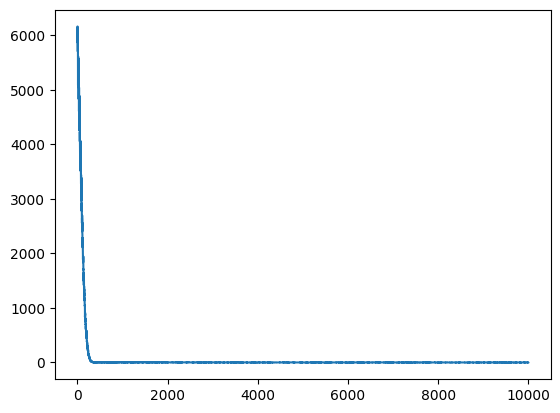

In [20]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [22]:
# RMSE calculation as previously
model.eval()
total_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs[:, :2], targets[:, :2])
        total_loss += loss.item()
rmse = np.sqrt(total_loss / len(test_loader))

# Display RMSE and plot learning curve
print(f"RMSE on Test Set: {rmse:.4f}")

RMSE on Test Set: 0.6414


### test the constraint violations

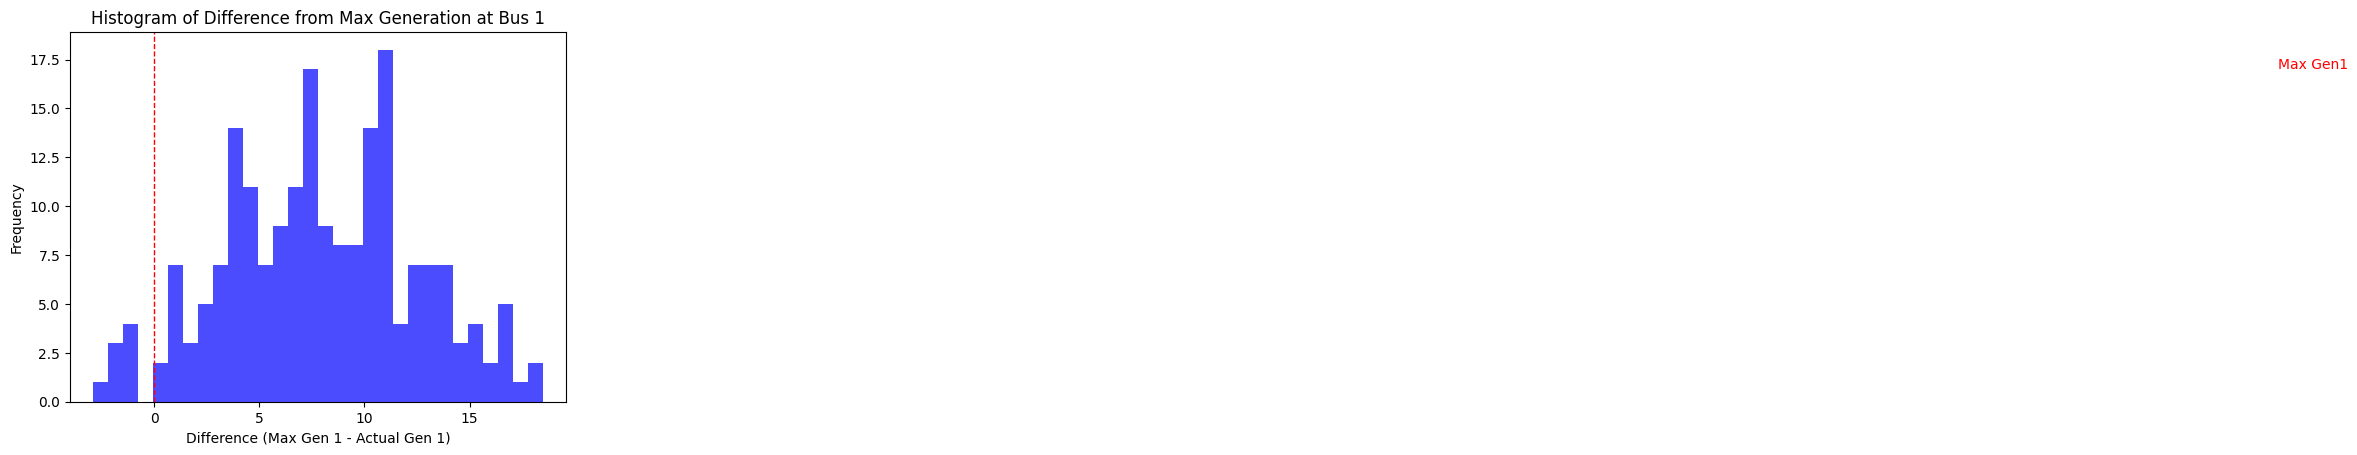

In [26]:
import matplotlib.pyplot as plt

# Assuming that test_loader is already set up and contains the necessary data
# Extract the additional output data from the test set
additional_output_values = []  # This will store the differences

# Evaluate the model to get outputs
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        additional_output_values.extend(outputs[:, 2].numpy())  # Assuming the third output is the difference

# Plot the histogram of the additional output values
plt.hist(additional_output_values, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Difference from Max Generation at Bus 1')
plt.xlabel('Difference (Max Gen 1 - Actual Gen 1)')
plt.ylabel('Frequency')

# Add a vertical line at the maximum generation limit
max_gen1 = 100  # maximum generation capacity for Gen1
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.text(max_gen1 + 1, plt.ylim()[1] * 0.9, 'Max Gen1', color='red')

plt.show()
